In [ ]:
!pip install -U scikit-learn 
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install pandas

# Adaboost

## Boosting

The underlying idea of boosting is to combine **cheap weak**
predictiors into a strong **powerful ensemble**.

![](https://www.researchgate.net/profile/Eiji_Hato/publication/264713074/figure/fig5/AS:614118558023749@1523428682764/Concept-of-AdaBoost.png)

### AdaBoost

This algorithm uses a greedy strategy to construct an additive ensemble of size $T$
from a dictionary of basis predictors.

The size of the ensemble $T$ is a regularization parameter:
* the greater the $T$, the more boosting overfits.

**`AdaBoost.M1`**:

![](https://telegra.ph/file/df511f4c8eef7b112ea76.jpg)

#### AdaBoost in SciKit

The `ensemble` submodule implements both classification and regression
versions of Adaboost
* AdaBoostClassifier
* AdaBoostRegressor

Algorithms differ only in the **loss** used in determining the weight updates.

In [1]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

### Adaboost params

Common parameters:
- **n_estimators** -- the maximum size of the ensemble (in **case of a perfect fit** boosting stops earlier);
- **base_estimator** -- the base estimator of the ensemble, which must support **sample weighting**;
- **learning_rate** -- scales each update, slowing down convergence, but making it more accurate.

AdaBoostClassifier only:
- **algorithm** -- the AdaBoost version to use:
    * _"SAMME"_ -- the SAMME (**M1**) discrete boosting algorithm;
    * _"SAMME.R"_ -- the SAMME.R real boosting algorithm, typically achieves a lower test error with fewer boosting iterations than `SAMME`.
    
AdaBoostRegressor only:
- **loss** -- the loss function to use when updating the weights after each boosting iteration:
    * _"linear"_ -- absolute loss $L(y, p) = |y-p|$;
    * _"square"_ -- squared loss $L(y, p) = |y-p|^2$;
    * _"exponential"_ -- Exponential loss $L(y, p) = 1-e^{-|y-p|}$.

# Practice: toy example

In [2]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, accuracy_score, mean_absolute_error, mean_squared_error, f1_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline

random_state = 1

/home/dvolkhonskiy/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def scikit_example(n_samples, random_state=None):
    X1, y1 = make_gaussian_quantiles(cov=2., n_samples=int(0.4*n_samples),
                                     n_features=2, n_classes=2,
                                     random_state=random_state)
    X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                     n_samples=int(0.6*n_samples),
                                     n_features=2, n_classes=2,
                                     random_state=random_state)
    return np.concatenate((X1, X2)), np.concatenate((y1, 1 - y2))

In [4]:
X, y = scikit_example(n_samples=500, random_state=random_state)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=random_state)


min_, max_ = np.min(X, axis=0) - 1, np.max(X, axis=0) + 1
xx, yy = np.meshgrid(np.linspace(min_[0], max_[0], num=51),
                     np.linspace(min_[1], max_[1], num=51))

In [5]:
def plot_adaboost(adaboost=None):
    mpl.style.use('seaborn')
    colors = ['red','green','blue']

    ax = plt.figure(figsize=(12, 8)).add_subplot(111)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=mpl.colors.ListedColormap(colors))

    if adaboost:
        prob_ = adaboost.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
        ax.contourf(xx, yy, prob_, alpha=0.4, cmap=plt.cm.coolwarm)
        ax.set_title("AdaBoost with %d trees"%(adaboost.n_estimators,));

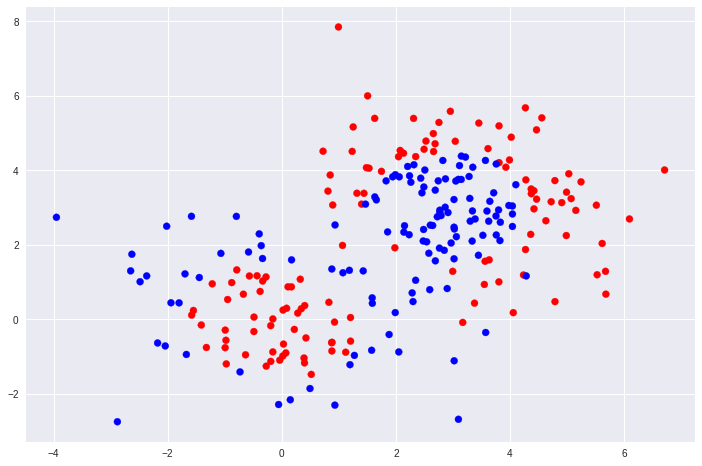

In [6]:
plot_adaboost()

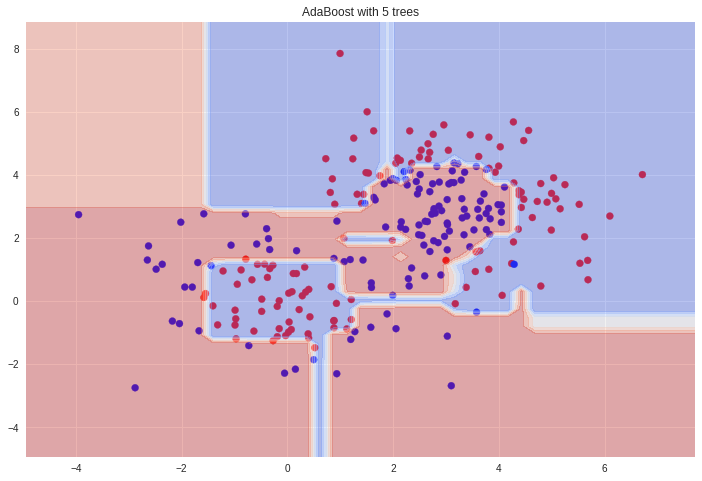

In [7]:
abc1_ = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                          n_estimators=5, random_state=random_state)
abc1_.fit(X_train, y_train)


plot_adaboost(abc1_)

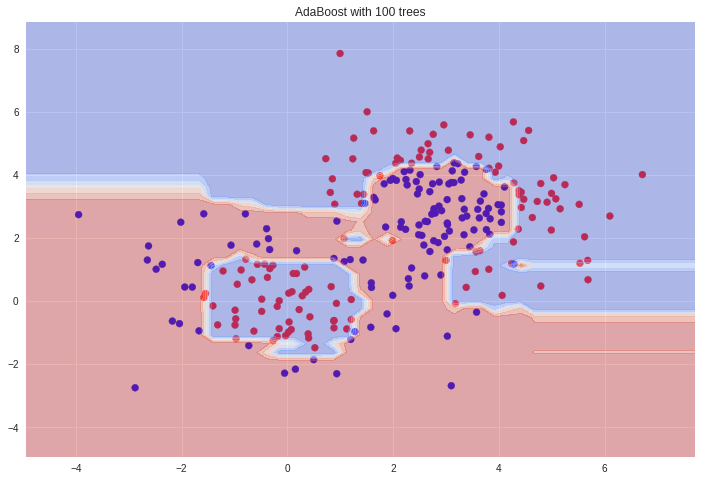

In [8]:
abc2_ = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                          n_estimators=100, random_state=random_state)
abc2_.fit(X_train, y_train)

plot_adaboost(abc2_)

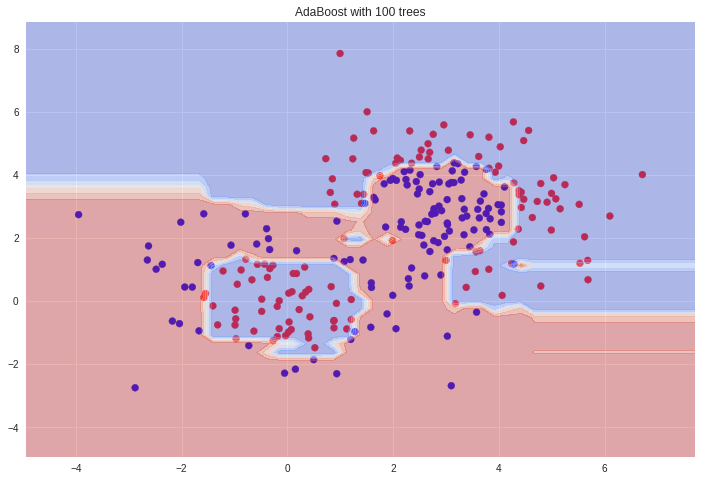

In [9]:
abc3_ = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                          n_estimators=1000, random_state=random_state)
abc3_.fit(X_train, y_train)

plot_adaboost(abc2_)

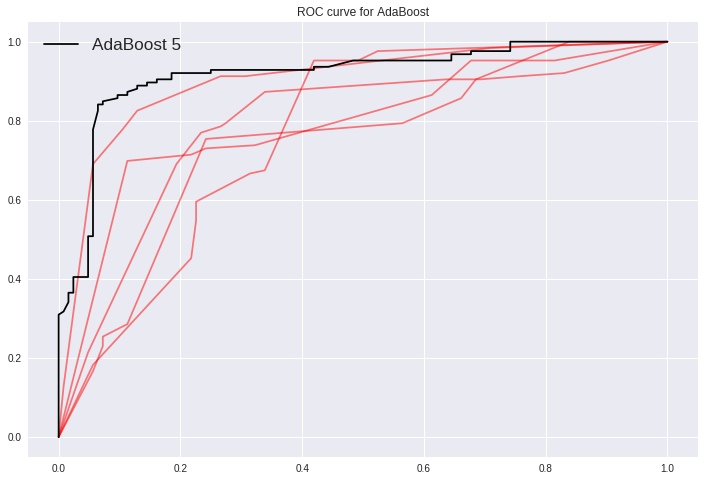

In [10]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
for est_ in abc1_.estimators_:
    fpr, tpr, _ = roc_curve(y_test, est_.predict_proba(X_test)[:, 1])
    ax.plot(fpr, tpr, color="red", alpha=0.5)

fpr, tpr, _ = roc_curve(y_test, abc1_.predict_proba(X_test)[:, 1])
ax.plot(fpr, tpr, color="black", label="AdaBoost %d"%(abc1_.n_estimators,))

ax.legend(fontsize="xx-large")
ax.set_title("ROC curve for AdaBoost");

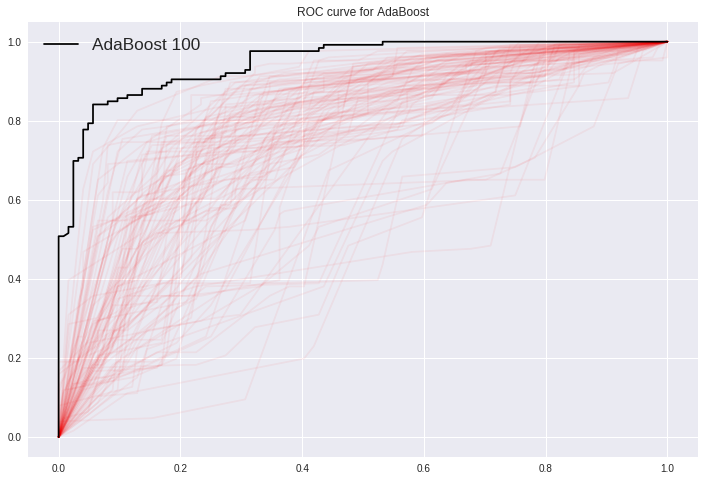

In [11]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
for est_ in abc2_.estimators_:
    fpr, tpr, _ = roc_curve(y_test, est_.predict_proba(X_test)[:, 1])
    ax.plot(fpr, tpr, color="red", alpha=0.05)

fpr, tpr, _ = roc_curve(y_test, abc2_.predict_proba(X_test)[:, 1])
ax.plot(fpr, tpr, color="black", label="AdaBoost %d"%(abc2_.n_estimators,))

ax.legend(fontsize="xx-large")
ax.set_title("ROC curve for AdaBoost");

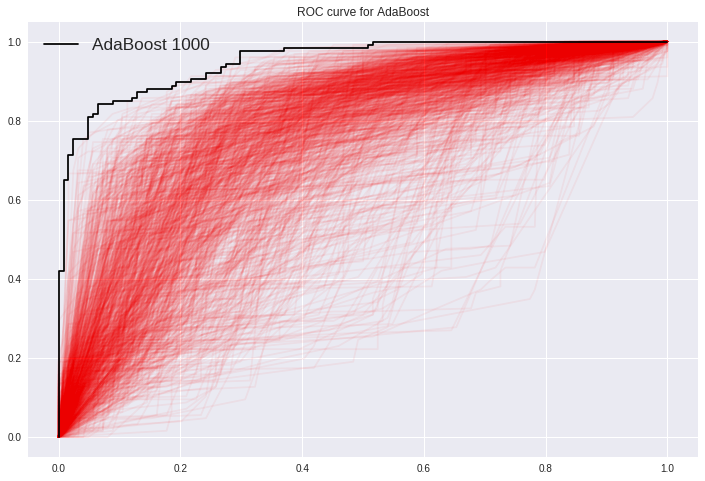

In [12]:
ax = plt.figure(figsize=(12, 8)).add_subplot(111)
for est_ in abc3_.estimators_:
    fpr, tpr, _ = roc_curve(y_test, est_.predict_proba(X_test)[:, 1])
    ax.plot(fpr, tpr, color="red", alpha=0.05)

fpr, tpr, _ = roc_curve(y_test, abc3_.predict_proba(X_test)[:, 1])
ax.plot(fpr, tpr, color="black", label="AdaBoost %d"%(abc3_.n_estimators,))

ax.legend(fontsize="xx-large")
ax.set_title("ROC curve for AdaBoost");

# Adult dataset


Download the dataset. If you use Windows, you can download it manually by the link [https://github.com/amueller/advanced_training/raw/master/data/adult.csv](https://github.com/amueller/advanced_training/raw/master/data/adult.csv)

In [ ]:
!wget https://github.com/amueller/advanced_training/raw/master/data/adult.csv

Let's look at it. We have some information about different persons. Our target value will be the income column. Since we have the information whether the income is above or below 50K, we will solve binary classification problem.

In [13]:
data = pd.read_csv('adult.csv', index_col=0)
print(data.shape)
data.head()

(32561, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [14]:
size_before = data.shape[0]
(data.astype(str) == ' ?').any()

age               False
workclass          True
education         False
education-num     False
marital-status    False
occupation         True
relationship      False
race              False
gender            False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country     True
income            False
dtype: bool

In [15]:
data = data[data.workclass != ' ?']
data = data[data.occupation != ' ?']
data = data[data['native-country'] != ' ?']

# data = data[np.logical_and(data.workclass != ' ?', data.occupation != ' ?')]

size_after = data.shape[0]

(data.astype(str) == '?').any()

age               False
workclass         False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
gender            False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
income            False
dtype: bool

In [16]:
data.shape

(30162, 14)

Let's conver our target income to binary value (0 and 1). 

In [17]:
if 'income' in data.columns:
    y = (data['income'] == ' >50K').values.astype(np.int32)
    del data['income']
    
del data['native-country']
    
y.shape

(30162,)

We have some categorical data in our dataset. Let us use one-hot-encoding for this columns. In order to automaticalli convert the data you should use method pd.get_dummies()

In [18]:
data = pd.get_dummies(data, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender'])
data.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,gender_ Female,gender_ Male
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,13,0,0,13,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,38,9,0,0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
3,53,7,0,0,40,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,28,13,0,0,40,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0


In [19]:
data.shape, y.shape

((30162, 62), (30162,))

# should we scale our data before AdaBoost?

![](https://telegra.ph/file/db989d671719e18433b57.jpg)

In [20]:
from sklearn.preprocessing import scale

X = scale(data.astype(np.float))

!!! Don't change random state

In [21]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)

X_val, X_test, y_val, y_test = \
    train_test_split(X_test, y_test, test_size=0.5, random_state=9, stratify=y_test)

In [22]:
X_train.shape, X_val.shape, X_test.shape

((24129, 62), (3016, 62), (3017, 62))

In [23]:
def get_test_train_errors(_adaboost):
    train_errors = []

    for y in _adaboost.staged_predict(X_train):
        train_errors.append(f1_score(y_train, y))

    test_errors = []

    for y in _adaboost.staged_predict(X_val):
        test_errors.append(f1_score(y_val, y))
        
    print('F1 validation score:', f1_score(y_val, _adaboost.predict(X_val)))
    
    plt.figure(figsize=(12, 8))
    plt.plot(train_errors, label='train')
    plt.plot(test_errors, label='test')
    plt.legend(loc='best')

## F1 score

Since we consider binary classification, it is good to use some proper measure. One of them — F1


$$F1 = 2 * (precision * recall) / (precision + recall)$$

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)

Let's train AdaBoost with a lot of small trees

/home/dvolkhonskiy/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dvolkhonskiy/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 validation score: 0.7268817204301076


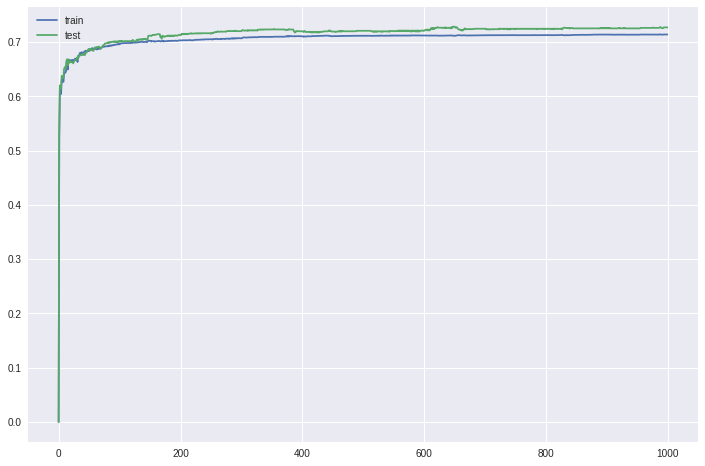

In [24]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=1000)
adaboost.fit(X_train, y_train)

get_test_train_errors(adaboost)

Now, increase the depth of trees

F1 validation score: 0.6560992419021364


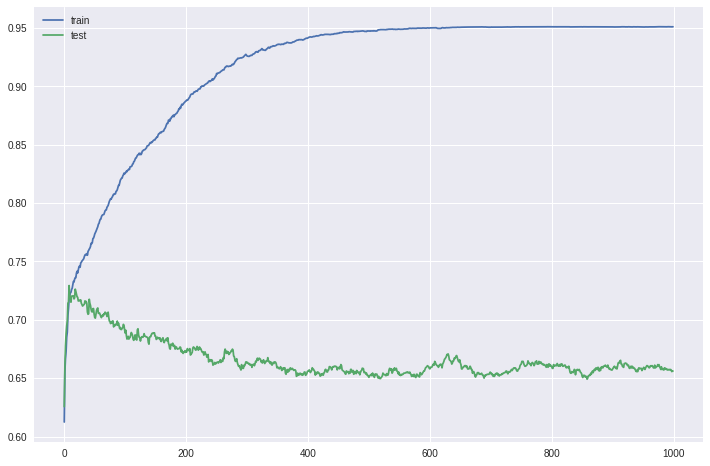

In [25]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=1000)
adaboost.fit(X_train, y_train)

get_test_train_errors(adaboost)

Leave trees depth as 5, decrease n_estimators to 200

F1 validation score: 0.6851211072664359


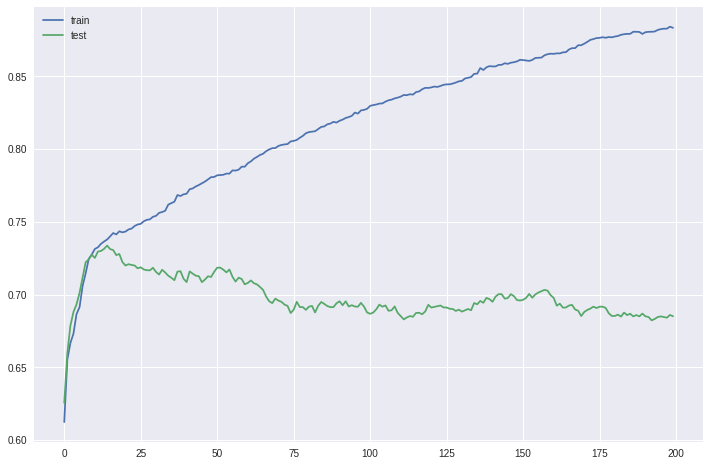

In [26]:
adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=200)
adaboost.fit(X_train, y_train)

get_test_train_errors(adaboost)

## Hello, overfitting!

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Overfitting.svg/300px-Overfitting.svg.png)

# Early stopping

Ok, we understood, that we don't need to much trees: we overfit. But if we take not enough trees, we will overfit. Here comes the regularization.

And one of the best regularization methods (best in practice), that is applied to ensembles (and to NN) is early stopping.

## The idea behind it is simple: if our validation loss didn't increase last 'n_tolerance' steps, then we stop adding new trees.

![](https://deeplearning4j.org/images/guide/earlystopping.png)


Let's implement Early Stopping for adaboost algorithm. We will extend the class AdaBoostClassifier. In order to implement the Early Stopping, you should understand, that it is easier to cut the final algorithm (select only a number of first trees) instead of training it each time.

In [27]:
class EarlyStoppingAdaBoost(AdaBoostClassifier):
    def __init__(self, n_tolerance, score_func, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_tolerance = n_tolerance
        self.score_func = score_func
        
    def fit(self, X_train, y_train, X_val, y_val):
        # train big AdaBoost
        super().fit(X_train, y_train)
        
        # Now you have to write an early stopping algorithm
        ######################
        # YOUR CODE HERE!
        
        val_scores = []
        wait = 1
        n_trees = 0
        
        for y_pred in self.staged_predict(X_val):
            n_trees += 1
            current_val_score = self.score_func(y_val, y_pred)
            
            if len(val_scores) > 0 and current_val_score > np.max(val_scores[-self.n_tolerance:]):
                # validation loss increased
                wait = 1
            else:
                if wait > self.n_tolerance:
                    # last self.n_tolerance validation score didn't decrease
                    break
                else:
                    # validation score didn't increase, but let's wait
                    wait += 1
                    
            val_scores.append(current_val_score)
                    
        self.estimators_ = self.estimators_[:n_trees]
        
        # YOUR CODE HERE!
        ######################
        
        return self

F1 validation score: 0.724841660802252


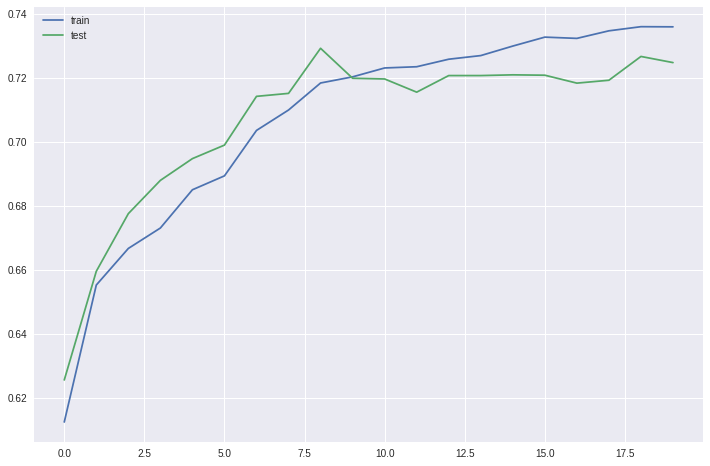

In [28]:
adaboost = EarlyStoppingAdaBoost(base_estimator=DecisionTreeClassifier(max_depth=5),
                                 n_estimators=200,
                                 n_tolerance=10, score_func=f1_score)
adaboost.fit(X_train, y_train, X_val, y_val)

get_test_train_errors(adaboost)

/home/dvolkhonskiy/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dvolkhonskiy/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dvolkhonskiy/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 validation score: 0.6641509433962264


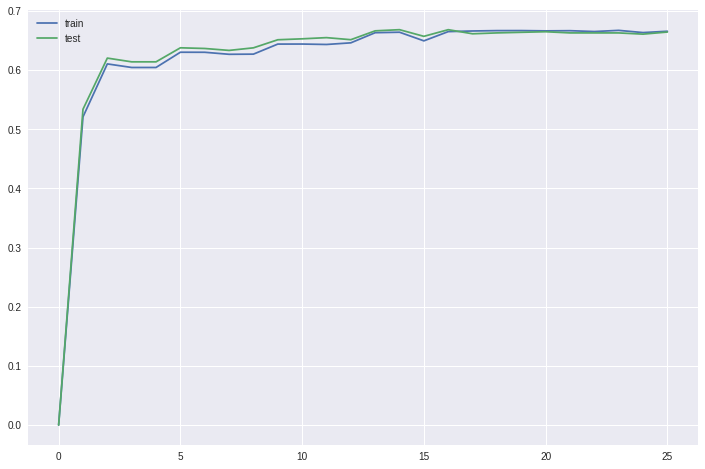

In [29]:
adaboost = EarlyStoppingAdaBoost(base_estimator=DecisionTreeClassifier(max_depth=1),
                                 n_estimators=1000,
                                 n_tolerance=10, score_func=f1_score)
adaboost.fit(X_train, y_train, X_val, y_val)

get_test_train_errors(adaboost)

# Feature Importance: how?

In [30]:
importances = adaboost.feature_importances_
std = np.std([tree.feature_importances_ for tree in adaboost.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, data.columns[f], importances[indices[f]]))

Feature ranking:
1. feature age (0.004000)
2. feature education-num (0.003000)
3. feature capital-gain (0.003000)
4. feature capital-loss (0.003000)
5. feature hours-per-week (0.002000)
6. feature workclass_ Federal-gov (0.001000)
7. feature workclass_ Local-gov (0.001000)
8. feature workclass_ Private (0.001000)
9. feature workclass_ Self-emp-inc (0.001000)
10. feature workclass_ Self-emp-not-inc (0.001000)
11. feature workclass_ State-gov (0.001000)
12. feature workclass_ Without-pay (0.001000)
13. feature education_ 10th (0.001000)
14. feature education_ 11th (0.001000)
15. feature education_ 12th (0.001000)
16. feature education_ 1st-4th (0.001000)
17. feature education_ 5th-6th (0.000000)
18. feature education_ 7th-8th (0.000000)
19. feature education_ 9th (0.000000)
20. feature education_ Assoc-acdm (0.000000)
21. feature education_ Assoc-voc (0.000000)
22. feature education_ Bachelors (0.000000)
23. feature education_ Doctorate (0.000000)
24. feature education_ HS-grad (0.000000

# Stacking: Voting

Imagine you have two powerful algorithms, such as SVM and AdaBoost. You found the best hyperparameters for each of the algorithms. Usually in practice you can increase the prediction quality by combining two algorithms using stacking.

One of the way to perform stacking is voting. If you have two algorithms $clf_1(x)$ and $clf_2(x)$, then the prediction will be 

$$result(x) = clf_1(x) * \alpha + clf_2(x) * (1 - \alpha),$$

where $\alpha \in [0, 1]$

In [31]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

In [32]:
clf1 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                                 n_estimators=20)
clf2 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                 n_estimators=50)


mix_clf_scores = []
for alpha in np.linspace(0., 1., 10):
    clf = VotingClassifier([('clf1', clf1), ('clf2', clf2)], 'soft', [alpha, 1-alpha])
    clf.fit(X_train, y_train)
    
    f1 = f1_score(y_val, clf.predict(X_val))
    
    mix_clf_scores.append(f1)


Text(0.5,1,'VotingClassifier scores depending from weights')

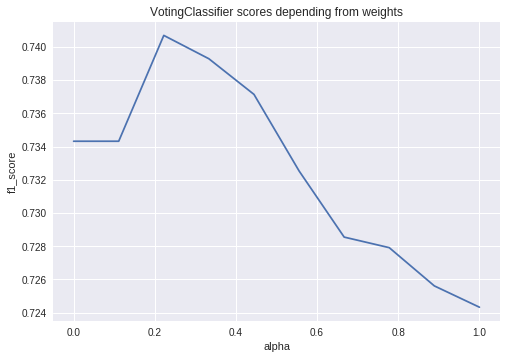

In [33]:
plt.plot(np.linspace(0., 1., 10), mix_clf_scores)
plt.xlabel('alpha')
plt.ylabel('f1_score')
plt.title('VotingClassifier scores depending from weights')

# Stacking: Meta-learner

![](https://blogs.sas.com/content/subconsciousmusings/files/2017/05/modelstacking.png)

Another possible solution for combination of several algorithms: learning some meta algorithm on the top of some base algorithms. For example, you have trained such algorithms, as SVM, Random Forest and Adaboost on your dataset. Each of these algorithms is able to return some scores, that you can use as features of the input objects. After it you can train some easy linear model (linear regression, logistic regression) on this features (which are the output of base algorithms).

## What we can use as the information from the base algorithms?

![](https://telegra.ph/file/f8b9d813663403520cfc6.jpg)

If you would like to construct such kind of stacking, you should be aware of overfitting. If you use the same train set for both base learners and meta learners, you will overfit.



So, your task for now is to implement stacking. You can choose what to do yourself:

* Use K-fold stacking
* Split your data into train and calibration sets
* Use train set for both training and calibration, and then obtain overfitting



In [280]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.base import clone

class MetaLogisticRegression(LogisticRegression):
    def __init__(self, base_learners, penalty='l2', dual=False, tol=0.0001,
                 C=1.0, fit_intercept=True, intercept_scaling=1,
                 class_weight=None, random_state=None, solver='liblinear',
                 max_iter=100, multi_class='ovr', verbose=0,
                 warm_start=False, n_jobs=None):
        super().__init__(penalty, dual, tol, C, fit_intercept, intercept_scaling,
                         class_weight, random_state, solver, max_iter, multi_class,
                         verbose, warm_start, n_jobs)
        self.base_learners = base_learners
        
        
    def fit_predict_base_learners(self, _X, _y):
        # write a function, that will feat each base classiffier and
        # return predictions of base learners for the train set (M1, M2 in algorithm)
        # HINT: from sklearn.model_selection import KFold
        # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
        ######################
        # YOUR CODE HERE!
        
        base_predictions = []
        
        for alg in self.base_learners:
            y_pred = cross_val_predict(alg, _X, _y, cv=5)
            base_predictions.append(y_pred)
            
        return np.vstack(base_predictions).T
        
        # YOUR CODE HERE!
        ######################
        
    def fit_base_learners_full(self, _X, _y):
        # write a function to fit a base learners on the whole(!) train set
        ######################
        # YOUR CODE HERE!
        
        for alg in self.base_learners:
            alg.fit(_X, _y)
        
        # YOUR CODE HERE!
        ######################
        
    def get_base_predictions(self, _X):
        # write a function, get the predictions of each base algorithm and return it
        # in the form of matrix of shape [X.shape[0], n_base_algorithms]
        ######################
        # YOUR CODE HERE!
        
        base_predictions = []
        
        for i, alg in enumerate(self.base_learners):
            base_predictions.append(alg.predict(_X))
                
        return np.vstack(base_predictions).T
        
        # YOUR CODE HERE!
        ######################
        
    def fit(self, _X, _y):
        # K-fold fitting of base learners
        base_predictions = self.fit_predict_base_learners(_X, _y)
        
        # learn meta Logistic Regression
        super().fit(base_predictions, _y)
        
        # fitting for test predictions
        self.fit_base_learners_full(_X, _y)        
        return self
    
    def predict(self, _X):
        base_predictions = self.get_base_predictions(_X)
        return super().predict(base_predictions)
        

In [281]:
clf1 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                                 n_estimators=20)
clf2 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                 n_estimators=50)

meta = MetaLogisticRegression(base_learners=[clf1, clf2])
meta.fit(X_train, y_train)

MetaLogisticRegression(C=1.0,
            base_learners=[AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1,...one,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)],
            class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr',
            n_jobs=None, penalty='l2', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [282]:
f1_score(y_val, meta.predict(X_val))

0.7198211624441133

# Snickers Challenge

Now let's check your imagination in designing ML algorithms. You task is to construct an algorithm in order to achive the highest f1 score on the dataset we considered today.

The winner will obtain:

![](https://www.utkonos.ru/resample/450x450q95/images/photo/3220/3220214H.jpg?mtime=5bb36059)

You have X_train, X_val, X_test. You can train/validate on both X_train and X_val on your choice. X_test — this is only for test prediction.

Key ingredients to success in Kaggle:
* Boosting
* Stacking
* Feature Engineering (removing non-important features, constructing new features)
* Data preprocessing (outliers)

You may start with stacking of several algorithms of different nature.

!!! Share your score here: https://goo.gl/forms/iINp60KzOwilIk6p1

In [ ]:
def get_test_score(y_pred):
    return f1_score(y_pred, y_test)

In [87]:
np.vstack([adaboost.predict(X_val), adaboost.predict(X_val)]).T

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int32)